In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm

In [2]:
!pip install pmdarima

In [4]:
file = "forecasting_monthly_data.xlsx"
df = pd.read_excel(file)
df

,Store,Month,Monthly_Sales,Avg_Fuel_Price,Avg_CPI
0,1,2010-02-01,6307344.10,2.54875,211.236828
1,1,2010-03-01,5871293.98,2.68600,211.241116
2,1,2010-04-01,7422801.92,2.77440,210.552135
3,1,2010-05-01,5929938.64,2.81850,210.547812
4,1,2010-06-01,6084081.46,2.66575,211.356237
...,...,...,...,...,...
1480,45,2012-06-01,4049712.68,3.62420,191.043707
1481,45,2012-07-01,3042463.41,3.55300,191.158753
1482,45,2012-08-01,3633793.89,3.77680,191.272273
1483,45,2012-09-01,2905011.08,3.97350,191.786947


In [5]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(['Store', 'Month'])

In [6]:
unique_ids = df['Store'].unique()



In [7]:
results = []

In [8]:
# Loop through each store
for store_id in unique_ids:
    # Get data for current store
    store_data = df[df['Store'] == store_id].copy()
    store_data = store_data.sort_values('Month').reset_index(drop=True)

    # Split into train (all except last month) and test (last month)
    train_data = store_data.iloc[:-1]
    test_data = store_data.iloc[-1:]

    # Set Month as index for time series
    train_data.set_index('Month', inplace=True)
    test_data.set_index('Month', inplace=True)

    # Extract monthly sales series
    train_series = train_data['Monthly_Sales']
    test_series = test_data['Monthly_Sales']

    try:
        # Fit the best ARIMA model automatically
        model = pm.auto_arima(train_series, seasonal=False, m=1, trace=False, suppress_warnings=True,
                              start_p=0, max_p=2, start_q=0, max_q=2)

        # Forecast the next 1 month
        forecast = model.predict(n_periods=1)

        # Calculate MAPE on training data (in-sample prediction)
        fitted_values = model.predict_in_sample()
        mape_train = np.mean(np.abs((train_series - fitted_values) / train_series)) * 100

        # Calculate MAPE on test data (forecast vs actual)
        mape_test = np.mean(np.abs((test_series.values - forecast) / test_series.values)) * 100

        # Store results for current store
        results.append({
            'Store': store_id,
            'Forecast_Month': test_series.index[0],
            'Actual_Sales': test_series.values[0],
            'Forecasted_Sales': forecast[0],
            'Train_MAPE': round(mape_train, 2),
            'Test_MAPE': round(mape_test, 2),
            'Model_Used': 'ARIMA'
        })

    except Exception as e:
        print(f"⚠️ ARIMA failed for Store {store_id}: {e}")


C:\Users\LopamudraMohapatra\AppData\Local\Temp\ipykernel_26760\3177691845.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Forecasted_Sales': forecast[0],
C:\Users\LopamudraMohapatra\AppData\Local\Temp\ipykernel_26760\3177691845.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Forecasted_Sales': forecast[0],
C:\Users\LopamudraMohapatra\AppData\Local\Temp\ipykernel_26760\3177691845.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

In [9]:
forecast_df = pd.DataFrame(results)

In [10]:
# Export to Excel
forecast_df.to_excel("arima_forecast_results_1months.xlsx", index=False)

# Print completion message
print(" ARIMA 1-month forecasting complete.")

 ARIMA 1-month forecasting complete.


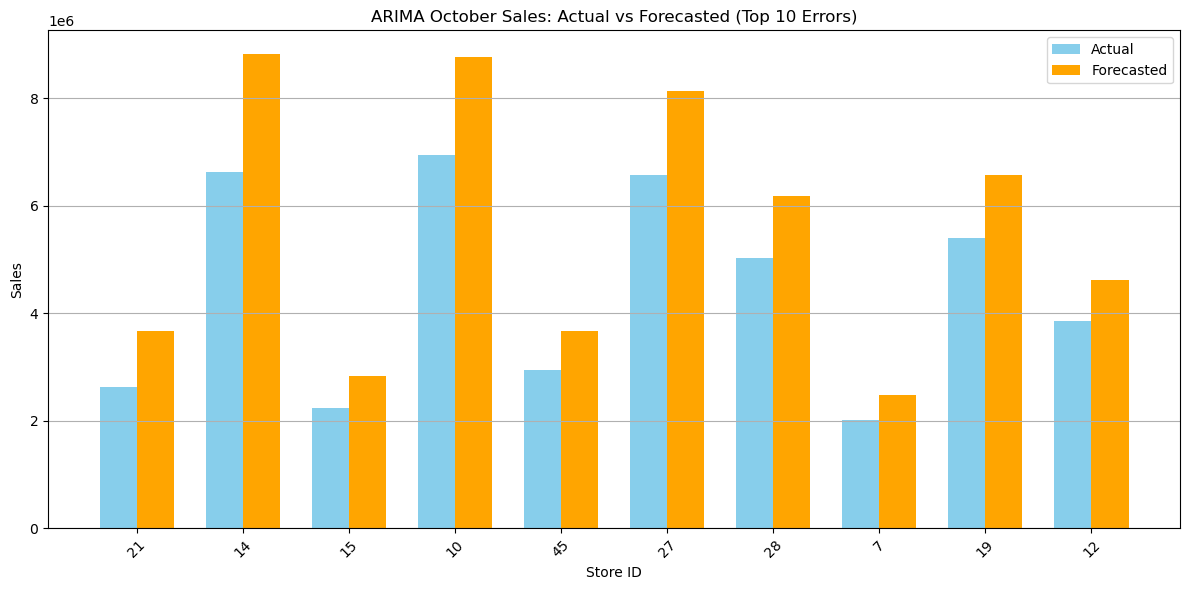

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by Test MAPE and take top N
top_n = 10
plot_df = forecast_df.sort_values("Test_MAPE", ascending=False).head(top_n)

x = np.arange(len(plot_df))
width = 0.35

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, plot_df['Actual_Sales'], width, label='Actual', color='skyblue')
plt.bar(x + width/2, plot_df['Forecasted_Sales'], width, label='Forecasted', color='orange')

# Formatting
plt.xticks(x, plot_df['Store'], rotation=45)
plt.ylabel('Sales')
plt.xlabel('Store ID')
plt.title(f'ARIMA October Sales: Actual vs Forecasted (Top {top_n} Errors)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
